In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Markdown as md
import pandas as pd

InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

time_zone = 'Asia/Jakarta'

In [2]:
import data_source
import yfinance as yf
from datetime import datetime, timedelta

In [3]:
tickers_sheet = 'tickers'
tickers = pd.read_excel('output_preprocessing.xlsx', sheet_name=tickers_sheet)

In [4]:
def generate_returns_of_market(start_time: datetime, end_time: datetime) -> pd.DataFrame:
    market_ticker = data_source.ticker_market
    market = yf.Ticker(ticker=market_ticker)

    result = market.history(start=start_time, end=end_time)
    returns_of_market = result['Close'].pct_change()[1:].to_frame()

    return_column_name = "return"
    first_column_name = returns_of_market.columns[0]
    returns_of_market.rename(columns={first_column_name: return_column_name}, inplace=True)

    return returns_of_market

In [13]:
def generate_stock_prices(start_time: datetime, end_time: datetime, tickers: pd.DataFrame, is_more_related: bool) -> pd.DataFrame:
    classified_tickers_list = tickers[tickers['is_more_related'] == is_more_related]['ticker'].to_list()

    tickers_prices = yf.download(tickers=classified_tickers_list, start=start_time, end=end_time)
    tickers_close_prices = tickers_prices['Close'].dropna(axis=1)

    return tickers_close_prices

In [14]:
def calculate_tickers_return(tickers_stock_prices: pd.DataFrame) -> pd.DataFrame:
    tickers_return = tickers_stock_prices.pct_change()[1:]
    return tickers_return

In [15]:
factor = 30

def select_winner_and_loser_tickers(tickers_stock_prices: pd.DataFrame, event_date: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    event_timestamp = pd.Timestamp(f'{event_date} 00:00:00')

    initial_stock_price_series = tickers_stock_prices.iloc[1]
    event_stock_price_series = tickers_stock_prices.loc[event_timestamp]
    formation_return_rate_series =  (event_stock_price_series - initial_stock_price_series) / initial_stock_price_series
    formation_return_rate_series = formation_return_rate_series.sort_values(ascending=False)
    

    winners_series = formation_return_rate_series[:factor]
    losers_series = formation_return_rate_series[-factor:]

    winner_tickers_list = winners_series.index.to_list()
    loser_tickers_list = losers_series.index.to_list()

    winner_tickers_return = tickers_return[winner_tickers_list]
    loser_tickers_return = tickers_return[loser_tickers_list]

    return winner_tickers_return, loser_tickers_return


In [16]:
date_column_name = 'date'
ticker_column_name = 'ticker'
return_column_name = 'return'
observation_param_name_for_return = 'param1_r'

In [17]:
def init_observation_df(input_df: pd.DataFrame) -> pd.DataFrame:
  observation_list = []
  for period, row in input_df.iterrows():
    period = period.tz_localize(time_zone)
    for ticker, daily_return in row.items():
      observation_list.append({
          date_column_name: period,
          ticker_column_name: ticker,
          return_column_name: daily_return
      })
  observation_raw_df = pd.DataFrame(observation_list)

  # raw pivot
  observation_df = observation_raw_df.pivot_table(index=date_column_name, columns=ticker_column_name)

  # fixed_pivot
  observation_df.rename(columns={return_column_name: observation_param_name_for_return}, inplace=True)
  observation_df = observation_df.swaplevel(i=0, j=1, axis=1)

  return observation_df

In [18]:
observation_param_name_for_mu = 'param2_mu'

In [19]:
def calculate_mu(observation_df: pd.DataFrame) -> pd.DataFrame:
  for column, _ in observation_df.items():
    _ticker, _ = column
    observation_df[_ticker, observation_param_name_for_mu] = observation_df[_ticker, observation_param_name_for_return] \
      - returns_of_market[return_column_name]
  observation_df = observation_df.reindex(sorted(observation_df.columns), axis=1)
  return observation_df

In [20]:
def generate_observation_aggregated_df(observation_df: pd.DataFrame) -> pd.DataFrame:
    observation_aggr_list = []
    car = 0
    i = - int(len(observation_df) / 2) + 1
    for index, row in observation_df.iterrows():
      u_series = row[:, observation_param_name_for_mu]
      ar = u_series.mean()
      car += ar

      observation_aggr_list.append({
          'period': i,
          'ar': ar,
          'car': car,
      })

      i += 1

    observation_aggr_df = pd.DataFrame(observation_aggr_list)
    observation_aggr_df = observation_aggr_df.pivot_table(index='period')
    return observation_aggr_df

In [21]:
def generate_winner_loser_comparison(winner_obs_aggr_df: pd.DataFrame, loser_obs_aggr_df: pd.DataFrame) -> pd.DataFrame:
    winner_car_series = winner_obs_aggr_df['car']
    loser_car_series = loser_obs_aggr_df['car']

    winner_loser_comparison = pd.concat({'car_winner': winner_car_series, 'car_loser': loser_car_series}, axis=1)
    return winner_loser_comparison

In [22]:
def plot_car_winner_loser(winner_loser_comparison: pd.DataFrame, case_code: str, is_more_related: bool):
    is_more_related_str = 'More-related' if is_more_related else 'Less-related'
    title = f'CAR Movement on the Case {case_code} for {is_more_related_str} Portfolio'
    winner_loser_comparison.plot(title=title, ylabel='CAR', xlabel='Period', grid=True, style=['o-','^-'])

In [23]:
%pdb off

Automatic pdb calling has been turned OFF


[*********************100%***********************]  357 of 357 completed


4 Failed downloads:
['MTFN.JK', 'MITI.JK', 'BMSR.JK', 'CENT.JK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-08-02 00:00:00 -> 2019-08-17 00:00:00)')



[*********************100%***********************]  243 of 243 completed
[*********************100%***********************]  357 of 357 completed
[*********************100%***********************]  243 of 243 completed


3 Failed downloads:
['BSIM.JK', 'BTPN.JK', 'TMAS.JK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-08-23 00:00:00 -> 2019-09-08 00:00:00)')



[*********************100%***********************]  357 of 357 completed
[*********************100%***********************]  243 of 243 completed
[*********************100%***********************]  357 of 357 completed
[*********************100%***********************]  243 of 243 completed
[*********************100%***********************]  357 of 357 completed
[*********************100%***********************]  243 of 243 completed


7 Failed downloads:
['BATA.JK', 'MERK.JK', 'SILO.JK', 'CASA.JK', 'FAST.JK', 'BBHI.JK', 'BMAS.JK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-11-20 00:00:00 -> 2019-12-05 00:00:00)')



[*********************100%***********************]  357 of 357 completed
[*********************100%***********************]  243 of 243 completed
[*********************100%***********************]  357 of 357 completed
[*********************100%***********************]  243 of 243 completed
[*********************100%***********************]  357 of 357 completed
[*********************100%***********************]  243 of 243 completed


4 Failed downloads:
['DNET.JK', 'FORU.JK', 'ATIC.JK', 'PDES.JK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-06-20 00:00:00 -> 2023-07-08 00:00:00)')


KeyError: 'date'

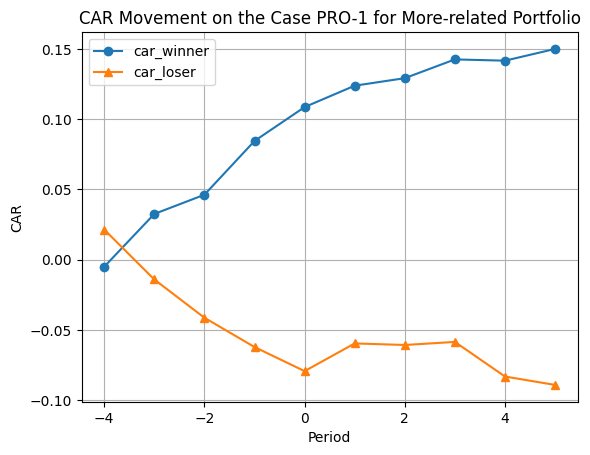

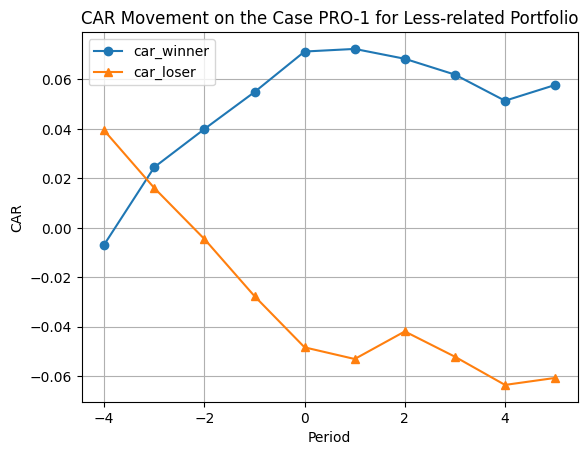

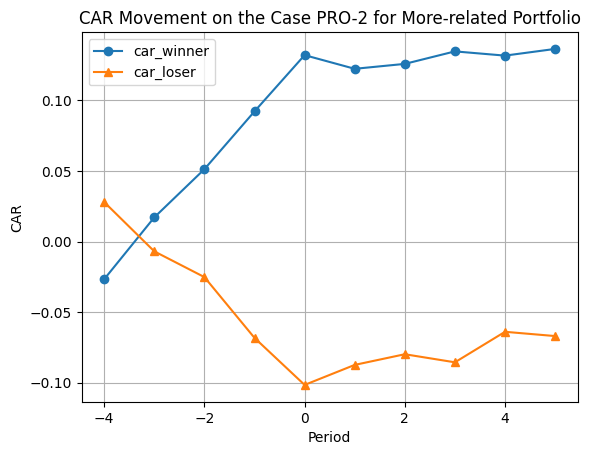

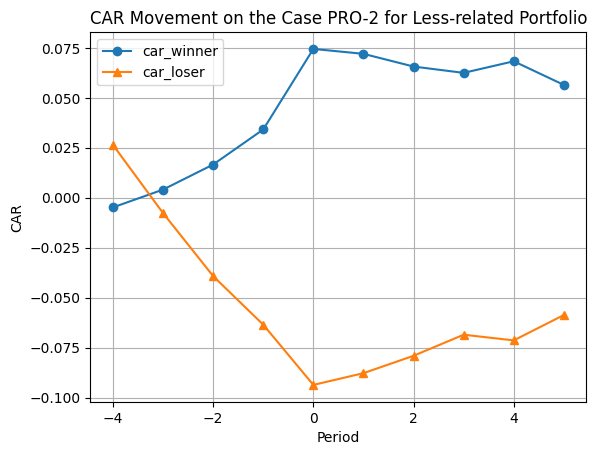

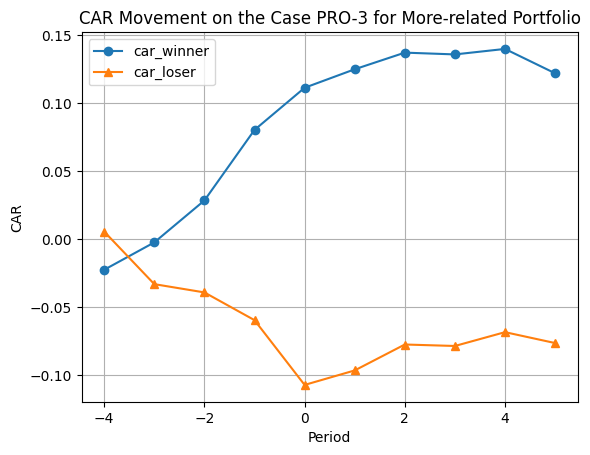

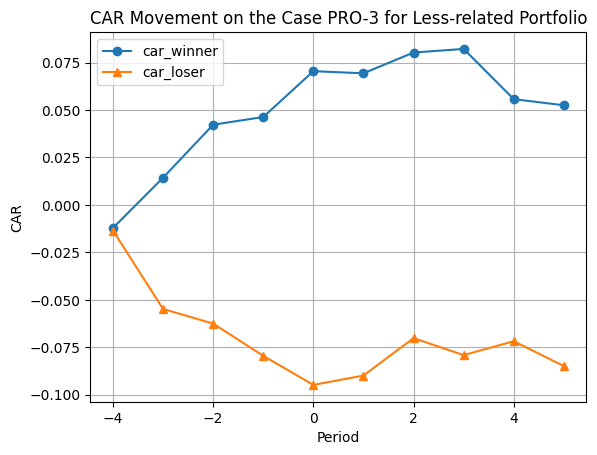

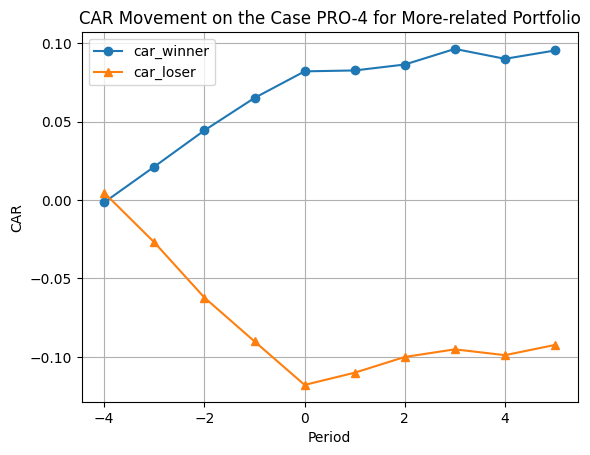

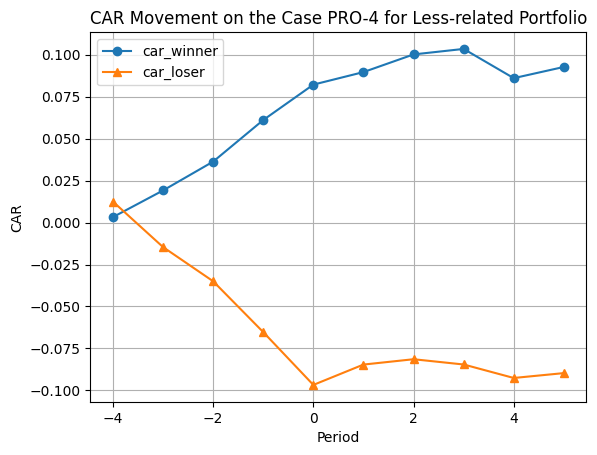

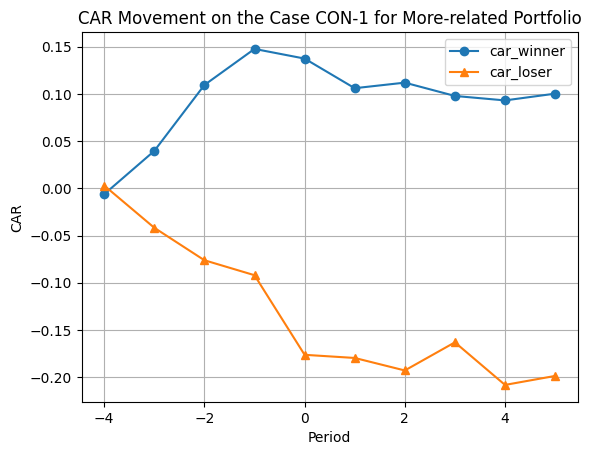

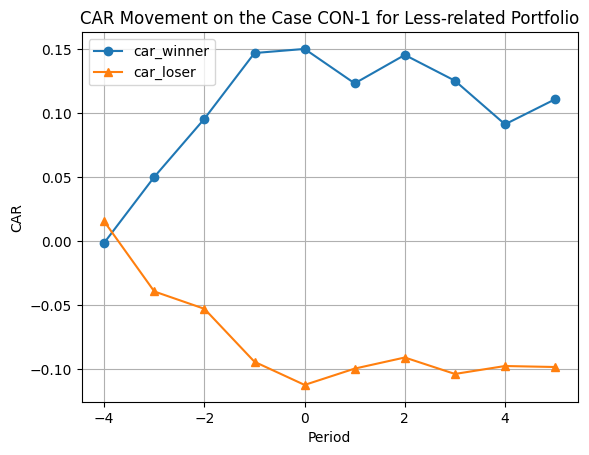

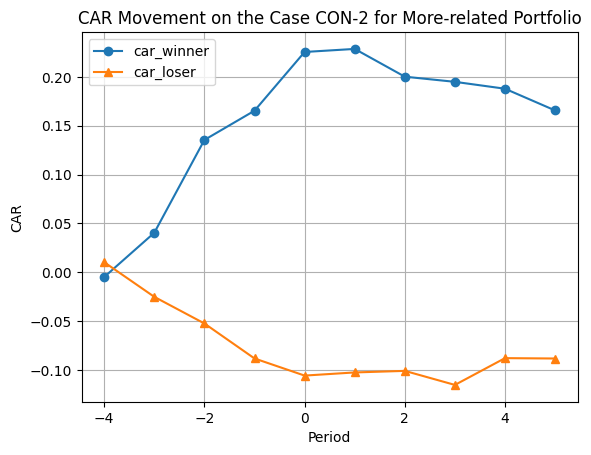

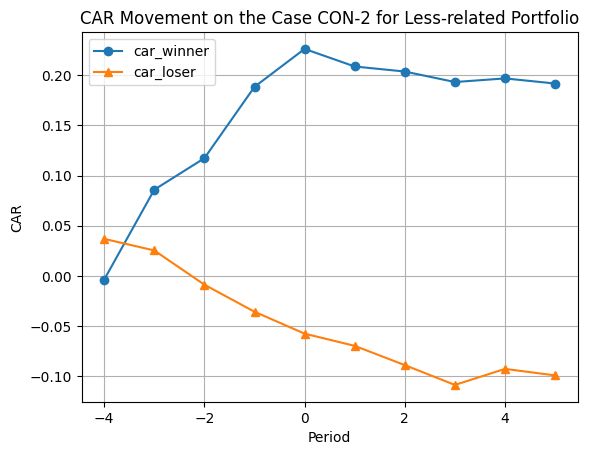

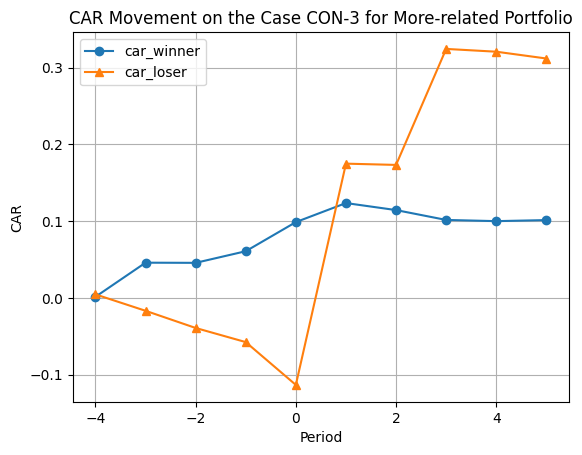

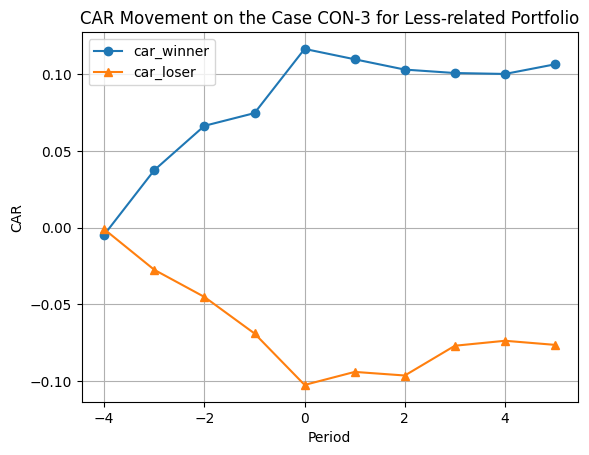

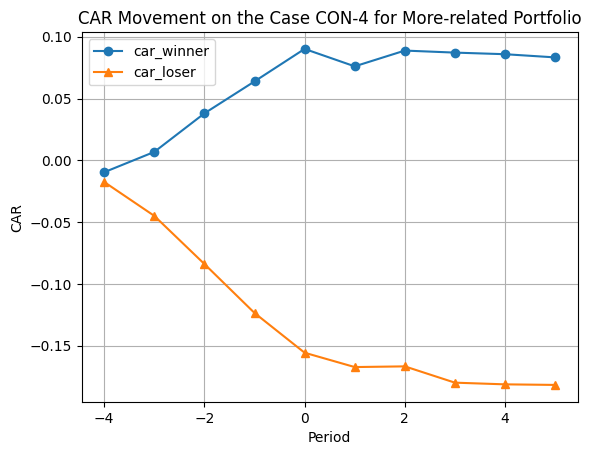

In [24]:
timeline = pd.read_excel('timeline.xlsx', sheet_name='timeline')

pro_or_con_column_name = 'pro_or_con'
pro_or_con_choice = ['PRO', 'CON']
is_more_related_choice = [True, False]

for pro_or_con in pro_or_con_choice:
    selected_pro_or_con = timeline[timeline[pro_or_con_column_name] == pro_or_con]
    for _, case in selected_pro_or_con.iterrows():
        case_code = case['code']
        start_date = case['start_date']
        event_date = case['event_date']
        end_date = case['end_date']

        start_time = datetime.strptime(start_date, '%Y-%m-%d')
        end_time = datetime.strptime(end_date, '%Y-%m-%d')

        returns_of_market = generate_returns_of_market(start_time=start_time, end_time=end_time)

        for is_more_related in is_more_related_choice:
            tickers_stock_prices = generate_stock_prices(start_time=start_time, end_time=end_time, tickers=tickers, is_more_related=is_more_related)
            tickers_return = calculate_tickers_return(tickers_stock_prices=tickers_stock_prices)
            
            winner_tickers_return, loser_tickers_return = select_winner_and_loser_tickers(tickers_stock_prices=tickers_stock_prices, event_date=event_date)
            
            winner_observation_df = init_observation_df(winner_tickers_return)
            loser_observation_df = init_observation_df(loser_tickers_return)

            winner_observation_df = calculate_mu(winner_observation_df)
            loser_observation_df = calculate_mu(loser_observation_df)

            winner_obs_aggr_df = generate_observation_aggregated_df(winner_observation_df)
            loser_obs_aggr_df = generate_observation_aggregated_df(loser_observation_df)

            winner_loser_comparison = generate_winner_loser_comparison(winner_obs_aggr_df=winner_obs_aggr_df, loser_obs_aggr_df=loser_obs_aggr_df)

            plot_car_winner_loser(winner_loser_comparison=winner_loser_comparison, case_code=case_code, is_more_related=is_more_related)
            